# Gradient Descent

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Generate $n$D Data

In [13]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), np.identity(n)))
    
    return series

[[0.69646919 0.         0.        ]
 [0.55131477 0.71946897 0.        ]
 [0.9807642  0.68482974 0.4809319 ]]


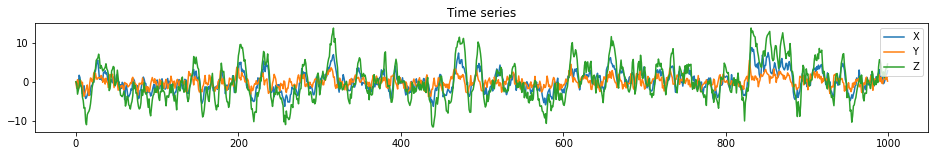

In [121]:
np.random.seed(seed = 123)

length, n = 1000, 3

# A matrix, lower triangular
A = np.tril(np.random.rand(n, n))
# A = np.tril(np.random.uniform(-1, 1, n ** 2).reshape((n, n)))
print(A)
# Permutation matrix
# P = np.array([[0.0, 1.0], [1.0, 0.0]])

# n = 3
P = np.array([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

# n = 4
# for this one to "work"
# P = np.array([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]])

# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

In [6]:
import itertools
P_list = np.array(list(itertools.permutations(np.identity(n))))

## Expected cost when $P = I$
$$\mathbb{E}\left[\sum_{t = 2}^T\frac{1}{T - 1}\left\lVert \mathbf{X}_t - A\mathbf{X}_{t-1}\right\rVert_ 2^2\right]$$
$$= \sum_{t = 2}^T\frac{1}{T - 1}\mathbb{E}\left[\sum_{i = 1}^n\left(X_{i, t} - \left(A\mathbf{X}_{t-1}\right)_i\right)^2\right]$$
$$= \sum_{t = 2}^T\frac{1}{T - 1}\sum_{i = 1}^n\mathbb{E}\left[\left(\left(A \mathbf{X_{t - 1}}\right)_{i} + \sigma_i^2- \left(A\mathbf{X}_{t-1}\right)_i\right)^2\right]$$
$$= n\sum_{i = 1}^n \sigma_i^2,$$
where $\sigma_i$ is the variance of the $i$th variable, assuming the covariance is a diagonal matrix.

In [122]:
from operator import itemgetter

cost = 0
    
for t in range(1, length):
    val = np.matmul(P, series[t])
    est = np.matmul(A, np.matmul(P, series[t - 1]))
    cost += np.linalg.norm(val - est) ** 2
    
print(cost / (length - 1))

results = list()
for P_i in P_list:
    cost = 0
 
    for t in range(1, length):
        val = np.matmul(P_i, series[t])
        est = np.matmul(A, np.matmul(P_i, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    results.append([cost / (length - 1), P_i])

results = sorted(results, key=itemgetter(0))

for elem in results:
    print("Cost:", elem[0])
    print("P w/ above cost:\n", elem[1])

2.9744089308715416
Cost: 2.9744089308715416
P w/ above cost:
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
Cost: 6.034083001806804
P w/ above cost:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Cost: 13.260007663692587
P w/ above cost:
 [[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
Cost: 30.594906400479566
P w/ above cost:
 [[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Cost: 34.63029045856225
P w/ above cost:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Cost: 49.08060552036053
P w/ above cost:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


### Find closest permutation matrix $P_{perm}$ to doubly stochastic matrix $P_{DS}$

In [101]:
def gen_P(n):
    P = np.random.random((n, n))
    rsum, csum = 0, 0

    # Sinkhorn balancing from a random matrix
    while (np.any(np.round(rsum, 3) != 1)) | (np.any(np.round(csum, 3) != 1)):
        P /= P.sum(0)
        P = P / P.sum(1)[:, np.newaxis]
        rsum = P.sum(1)
        csum = P.sum(0)
        
    return P

In [104]:
def P_ds_to_P_perm(P_DS):
    # convert to get the maximum linear assignment problem
    P_MOD = np.ones((n, n)) * np.max(P_DS) - P_DS
    row_ind, col_ind = optimize.linear_sum_assignment(P_MOD)

    # Create Permutation matrix to return
    P_perm = np.zeros((n, n))

    for row, col in zip(row_ind, col_ind):
        P_perm[row][col] = 1 
    
    return P_perm

P_DS_random = gen_P(n)
print(P_DS_random)
print(P_ds_to_P_perm(P_DS_random))

[[0.58925859 0.17218374 0.23855767]
 [0.14420296 0.38952894 0.46626811]
 [0.266099   0.43853491 0.29536609]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [105]:
# Randomly initialize A_hat and P_hat
P_hat = gen_P(n)
A_hat = np.tril(np.random.rand(n, n))
print(P_ds_to_P_perm(P_hat))
print(P_hat)
print(A_hat)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[[0.68288647 0.28295161 0.03416193]
 [0.17801153 0.30454094 0.51744753]
 [0.13929945 0.41247915 0.4482214 ]]
[[0.60054476 0.         0.        ]
 [0.79669326 0.35304526 0.        ]
 [0.74148586 0.87532871 0.44849798]]


# $n$ Dimensions, $n^2 + (n - 1)^2$ variables.
## Cost function $C(P, A)$
The cost function resembles a least squares function:
\begin{align*}
    C = \frac{1}{T - 1}\sum_{t = 2}^T(y_t - y_{t, pred})^2
\end{align*}

However, our $y_t$ is $n$-dimensional, so we take the $2$-norm. Furthermore, $y_t = P \mathbf{X}_t$, and $y_{pred, t} = A P \mathbf{X}_{t - 1}$. Plugging this all in yields

\begin{align}
    C(P, A) &= \frac{1}{T - 1}\sum_{t=2}^T \left\lVert P\mathbf{X}_t - AP\mathbf{X}_{t-1})\right\rVert_2^2 \\
      &= \frac{1}{T - 1}\sum_{t=2}^T \sum_{i = 1}^n \left(\left(P\mathbf{X}_t\right)_i - \left(AP\mathbf{X}_{t-1}\right)_i\right)^2.
\end{align}

In [115]:
def C_n(variables, l = 0.01):
    P, A  = variables
    P_perm = P_ds_to_P_perm(P)
    
    cost = 0
    
    for t in range(1, length):
        val = np.matmul(P_perm, series[t])
        est = np.matmul(A, np.matmul(P_perm, series[t - 1]))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost / (length - 1)

In [117]:
def C_n(variables, l = 0.01):
    P, A  = variables
    P_perm = P_ds_to_P_perm(P)
    
    cost = 0
    
    for t in range(1, length):
        val = series[t]
        est = np.matmul(P_perm.transpose(), np.matmul(A, np.matmul(P_perm, series[t - 1])))
        cost += np.linalg.norm(val - est) ** 2
    
    return cost / (length - 1)

print(C_n([P, A]))
print(C_n([P_hat, A_hat]))

2.974408930871541
6.014022351527549


### Partial derivative of $C(P, A)$ for arbitrary $a_{ij}$ and arbitrary dimension
Now, taking the derivative of $C(P, A)$ with respect to $a_{ij}$ and using the chain rule, we get

$$\frac{\partial C(P, A)}{\partial a_{ij}} = -2 \sum_{t=2}^T \left(P^* \mathbf{X}_t - AP\mathbf{X}_{t-1} \right)_{(i)} \cdot \left(P\mathbf{X}_{t-1}\right)_{(j)},$$

for $i, j = 1, ..., n.$

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
1 1, ...,  

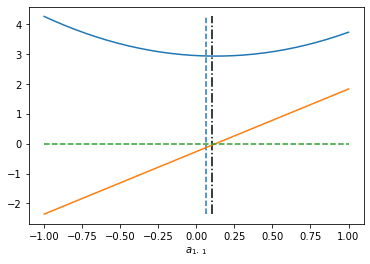

In [42]:
def C_aij_n(variables, i = 1, j = 1, l = 0.01):
    """Calculate the derivative of C w.r.t aij"""
    
    P, A  = variables
    
    # transform the P_DS to a P_perm for the actual value
    P_perm = P_ds_to_P_perm(P)
    
    derivative = 0
    
    for t in range(1, length):
        val = np.matmul(P_perm, series[t])[i - 1]
        est = np.matmul(A, np.matmul(P, series[t - 1]))[i - 1]
        
        derivative += -2 * (val - est) * np.matmul(P, series[t - 1])[j - 1]
        
    return derivative / (length - 1)

verify_gradient_a(1, 1, P, A)

### Partial derivative of $C(P, A)$ for arbitrary $p_{ij}$ and arbitrary dimension
Now, taking the derivative of $C(P, A)$ with respect to $p_{ij}$ and using the chain rule, we get

$$\frac{\partial C(P, A)}{\partial p_{ij}} = -2 \sum_{t=2}^T \left(P \mathbf{X}_t - AP\mathbf{X}_{t-1} \right)_{(i)} \cdot \left(P\mathbf{X}_{t-1}\right)_{(j)},$$

for $i, j = 1, ..., n.$

In [22]:
def verify_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    x_lim_1, x_lim_2 = -2., 2.
    p_list = np.linspace(x_lim_1, x_lim_2, 100)
    results = [[], []]

    for p in p_list:
        old_p = P[i - 1][j - 1]
        
        P[i - 1][n - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - p)
        P[i - 1][j - 1] = p
        
        results[0].append(C_n([P, A]))
        results[1].append(C_pij_n([P, A], i = i, j = j))

        P[i - 1][n - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - old_p)
        P[i - 1][j - 1] = old_p

    plt.xlabel(f"$p_{{{str(i) + str(j)}}}$")
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--')
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

In [12]:
print(A)

[[ 0.75186527  0.          0.        ]
 [ 0.36692587  0.42540405  0.        ]
 [ 0.12239237  0.00616633 -0.9724631 ]]


### Procedure
    While Cost Function changes:
        For $i, j = 1, ..., n - 1$:
            Approximate $p_{ij}$ using gradient descent
   
        For $i, j = 1, ..., n$:
            Approximate $a_{ij}$ using gradient descent

In [216]:
# Randomly initialize A_hat and P_hat
P_hat = gen_P(n)
A_hat = np.tril(np.random.rand(n, n))
print(P_ds_to_P_perm(P_hat))
print(P_hat)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]
[[0.02406454 0.6280035  0.34793197]
 [0.5213775  0.3615253  0.1170972 ]
 [0.45432524 0.0107825  0.53489225]]


In [217]:
def gradient_descent_fast(k):
    """
    Run Gradient Descent with Learning Parameter L on the kth variable until convergence.
    k is a number between 1 and ...
    """
    
    x1, x2 = 0.2, 0.5 # any arbitrary values, preferably between 0 and 1
    
    # If k is between 1 and n^2, estimate a_{k//n + 1, k%n + 1}
    if 1 <= k <= n ** 2:
        # get indices i, j = 1, ..., n
        i = (k - 1) // n + 1
        j = (k - 1) % n + 1
        
        # lower triangular constraint: , j !> i
        if i >= j:
            # compute y1
            A_hat[i - 1][j - 1] = x1
            y1 = C_aij_n([P_hat, A_hat], i, j) 
            
            # compute y2
            A_hat[i - 1][j - 1] = x2
            y2 = C_aij_n([P_hat, A_hat], i, j) 
            
            # compute A_ij_opt
            a = (y1 - y2) / (x1 - x2)
            b = y1 - a * x1
            A_hat[i - 1][j - 1] = -b / a
        
    elif n ** 2 < k <= n ** 2 + (n - 1) ** 2:
        # get indices i, j, in 1, ..., n - 1
        i = (k - n ** 2 - 1) // (n - 1) + 1
        j = (k - n ** 2 - 1) % (n - 1) + 1
        
        # print(f"Optimizing P[{i}][{j}].")
        p_dif_2 = P_hat[i - 1][j - 1]
        # compute y1
        p_dif = P_hat[i - 1][j - 1] - x1
        P_hat[i - 1][j - 1] -= p_dif 
        P_hat[i - 1][n - 1] += p_dif
        P_hat[n - 1][j - 1] += p_dif
        P_hat[n - 1][n - 1] -= p_dif
        
        y1 = C_pij_n([P_hat, A_hat], i, j) 
        
        # compute y2
        p_dif = P_hat[i - 1][j - 1] - x2
        P_hat[i - 1][j - 1] -= p_dif 
        P_hat[i - 1][n - 1] += p_dif
        P_hat[n - 1][j - 1] += p_dif
        P_hat[n - 1][n - 1] -= p_dif
        
        y2 = C_pij_n([P_hat, A_hat], i, j) 
        
        # compute p_ij_opt
        a = (y1 - y2) / (x1 - x2)
        b = y1 - a * x1
        p_ij_opt = -b / a
        
        # update P
        p_dif = P_hat[i - 1][j - 1] - p_ij_opt
        P_hat[i - 1][j - 1] -= p_dif 
        P_hat[i - 1][n - 1] += p_dif
        P_hat[n - 1][j - 1] += p_dif
        P_hat[n - 1][n - 1] -= p_dif
        
        print(p_ij_opt - p_dif_2)
# initialize cost, old_cost
cost, old_cost = C_n([P_hat, A_hat]), 1e10

# gradient descent until cost does not decrease by more than 1e-6
while abs(old_cost - cost) > 1e-5:
    
    # check old cost
    old_cost = cost
    
    # for all parameters
    for k in range(1, n ** 2 + (n - 1) ** 2 + 1):
        # cost_1 = C_n([P_hat, A_hat])
        # optimize parameter k using gradient descent fast
        gradient_descent_fast(k)
        # print(round(cost_1 - C_n([P_hat, A_hat]), 8))
    print(P_hat)
    
    # check new cost
    cost = C_n([P_hat, A_hat])
    
    # print cost difference
    print(round(cost, 5), end = " ")
    print("Cost diff.:", str(round(old_cost - cost, 8)), end = ", ")

# "convergence!" print results
print("\nOptimal cost:", C_n([P_hat, A_hat]))
print("\nP:\n", P_hat)
print("A:\n", A_hat)

0.089683336931226
-0.2547444930512307
-0.29788328746843173
-0.0032731193893247856
[[0.11374787 0.373259   0.51299312]
 [0.22349422 0.35825218 0.4182536 ]
 [0.6625252  0.26880011 0.06867469]]
23.84993 Cost diff.: 0.55285794, 0.07351641901400657
0.04124454583889059
0.16833006014480434
-0.014464516319351584
[[0.18726429 0.41450355 0.39823216]
 [0.39182428 0.34378767 0.26438806]
 [0.42067872 0.24202008 0.3373012 ]]
33.17032 Cost diff.: -9.32038328, 0.02380910092594385
-0.004881584626864777
0.04069774803795656
-0.11955304512844925
[[0.21107339 0.40962197 0.37930464]
 [0.43252202 0.22423462 0.34324336]
 [0.35617187 0.36645471 0.27737342]]
26.22295 Cost diff.: 6.94736302, -0.00022102696921752485
-0.05355812276054189
0.12239401382612336
-0.22505574023129324
[[ 0.21085237  0.35606384  0.43308379]
 [ 0.55491604 -0.00082112  0.44590508]
 [ 0.23399888  0.64506858  0.12093254]]
21.64499 Cost diff.: 4.57796186, -0.0493025226211499
0.1249934570290207
-0.07038843107261356
0.319882721500197
[[0.1615498

4.05964 Cost diff.: 0.06995897, -0.8374246513427668
0.8509320907476257
-0.2252595942647626
0.23179368135257583
[[ -8.47509715   8.31974158   1.15535557]
 [ -2.34926562   2.82573015   0.52353547]
 [ 11.82413005 -10.14516043  -0.67896962]]
4.01417 Cost diff.: 0.04546779, -0.8280817871726036
0.8503394088706209
-0.2198195584353999
0.22865370625354275
[[ -9.30317893   9.17008098   1.13309795]
 [ -2.56908518   3.05438386   0.51470132]
 [ 12.8720314  -11.22415354  -0.64787785]]
3.98318 Cost diff.: 0.03098562, -0.820620450179538
0.8504816910069994
-0.2152385731744353
0.22600687462236424
[[-10.12379938  10.02056267   1.10323671]
 [ -2.78432375   3.28039074   0.50393302]
 [ 13.90789042 -12.30064211  -0.60724831]]
3.96137 Cost diff.: 0.02180871, -0.814553611459333
0.8511330957806198
-0.21130754179480382
0.2237340531898644
[[-10.93835299  10.87169577   1.06665722]
 [ -2.99563129   3.50412479   0.49150651]
 [ 14.93375157 -13.37550926  -0.55824232]]
3.94569 Cost diff.: 0.0156835, -0.8095503294508433

4.17365 Cost diff.: 0.00608437, -0.7898456578549364
0.8443702672538187
-0.23177111203337564
0.25178247832620215
[[-14.73765586  14.41945339   1.31820248]
 [ -4.6649688    5.07263833   0.59233047]
 [ 20.40239195 -18.49178041  -0.91061153]]
4.16909 Cost diff.: 0.00455981, -0.7865447540305368
0.8450790130913699
-0.22914458042886032
0.25014977819883466
[[-15.52420062  15.2645324    1.25966822]
 [ -4.89411338   5.32278811   0.57132527]
 [ 21.41808128 -19.58700921  -0.83107207]]
4.16571 Cost diff.: 0.00338159, -0.7836989501732212
0.845955009122358
-0.22675960030423958
0.24866985644636497
[[-16.30789957  16.11048741   1.19741216]
 [ -5.12087298   5.57145796   0.54941502]
 [ 22.42853983 -20.68163407  -0.74690576]]
4.16325 Cost diff.: 0.00245755, -0.781234281283691
0.8469625033814268
-0.22458060493708754
0.24731990636969314
[[-17.08913385  16.95744991   1.13168394]
 [ -5.34545358   5.81877787   0.52667572]
 [ 23.43435472 -21.77591648  -0.65843824]]
4.16153 Cost diff.: 0.00172381, -0.77909195904

429.10722 Cost diff.: -6.44266205, -0.4836440556850272
0.02690948161430118
1.793107603265021
-0.055052146758059584
[[ -6.04288165   1.38870034   5.65418131]
 [ 21.99162864  -1.53015768 -19.46147096]
 [-14.94897971   1.14176864  14.80721107]]
435.51713 Cost diff.: -6.40991224, -0.5056299950164602
0.029514027935202858
1.880279481491307
-0.06680351499216775
[[ -6.54851164   1.41821437   6.13029728]
 [ 23.87190812  -1.59696119 -21.27494693]
 [-16.32362919   1.17905812  16.14457107]]
442.16694 Cost diff.: -6.64980572, -0.5241288691450876
0.03034557649389802
1.955068854703594
-0.07094290054138574
[[ -7.07264051   1.44855995   6.62408057]
 [ 25.82697698  -1.66790409 -23.15907288]
 [-17.75456918   1.21965545  17.53491373]]
449.18388 Cost diff.: -7.01694543, -0.5412256572168284
0.030481952418868197
2.0249827891933236
-0.07204941009932386
[[ -7.61386617   1.4790419    7.13482427]
 [ 27.85195977  -1.7399535  -25.11200626]
 [-19.23832631   1.26122291  18.9771034 ]]
456.60356 Cost diff.: -7.4196736

-0.06262190603351048
[[ -34.65847271    2.40860056   33.24987215]
 [ 133.50455964   -3.92418786 -128.58037178]
 [ -97.84631965    2.5158986    96.33042105]]
894.76327 Cost diff.: -18.69861911, -1.1006258190285436
0.02686536997701383
4.417269527110562
-0.06249850598961659
[[ -35.75909852    2.43546593   34.32363259]
 [ 137.92182917   -3.98668636 -132.93514281]
 [-101.16296336    2.55153173   99.61143163]]
913.81828 Cost diff.: -19.05501471, -1.1173857320032852
0.02682570742118484
4.491131151456727
-0.062379833925898964
[[ -36.87648426    2.46229164   35.41419262]
 [ 142.41296032   -4.0490662  -137.36389412]
 [-104.53670878    2.58708586  102.94962292]]
933.23174 Cost diff.: -19.41345199, -1.1341654177007072
0.026787678871703857
4.565184559891065
-0.062265643085913425
[[ -38.01064967    2.48907932   36.52157036]
 [ 146.97814488   -4.11133184 -141.86681304]
 [-107.96772792    2.62256383  106.3451641 ]]
953.00567 Cost diff.: -19.77393383, -1.15096481964094
0.026751198079191685
4.6394284992

1820.88661 Cost diff.: -32.78196555, -1.7158559035379994
0.02607252348427158
7.188602044757374
-0.0599894478238161
[[ -86.69217014    3.3849477    84.30722243]
 [ 347.54579576   -6.18180592 -340.36398984]
 [-259.85385834    3.79716952  257.05668882]]
1854.09479 Cost diff.: -33.20818643, -1.733273391185861
0.026061542841876673
7.268636298638796
-0.05995092374769939
[[ -88.42544353    3.41100924   86.01443428]
 [ 354.81443206   -6.24175684 -347.57267521]
 [-265.38922124    3.8310589   262.55816234]]
1887.73098 Cost diff.: -33.63618586, -1.750707359983224
0.026050899209029588
7.348822839587001
-0.05991337373291117
[[ -90.17615089    3.43706014   87.73909074]
 [ 362.16325489   -6.30167022 -354.86158468]
 [-270.98733672    3.86492137  268.12241535]]
1921.79693 Cost diff.: -34.06595507, -1.7681577147392602
0.0260405806594477
7.429160766769201
-0.05987676474762349
[[ -91.9443086     3.46310072   89.48120788]
 [ 369.59241566   -6.36154698 -362.23086868]
 [-276.64833978    3.89875756  273.74958

3298.17461 Cost diff.: -49.18839379, -2.352627377557468
0.02582759931403089
10.159892335207815
-0.059044005044276204
[[-160.18508351    4.31825681  156.8668267 ]
 [ 660.76617638   -8.32165096 -651.44452542]
 [-499.58132559    5.00370545  495.57762014]]
3347.84828 Cost diff.: -49.67367513, -2.3705829254403454
0.025823833332517587
10.244906185091736
-0.05902684439126382
[[-162.55566643    4.34408064  159.21158579]
 [ 671.01108257   -8.3806778  -661.63040476]
 [-507.45564885    5.03690846  503.41874039]]
3398.00875 Cost diff.: -50.16046795, -2.3885519473459738
0.025820176792292315
10.330045373720395
-0.05901001963944452
[[-164.94421838    4.36990082  161.57431756]
 [ 681.34112794   -8.43968782 -671.90144012]
 [-515.39714228    5.07009831  511.32704397]]
3448.65751 Cost diff.: -50.64876616, -2.4065343720342582
0.025816626304081325
10.415309291717563
-0.05899352358528809
[[-167.35075275    4.39571744  163.95503531]
 [ 691.75643723   -8.49868135 -682.25775589]
 [-523.4059172     5.1032752   

5403.51949 Cost diff.: -67.57040923, -3.0070424241876594
0.02574420811341671
13.295309858261817
-0.05859040313272956
[[ -256.93831725     5.24622985   252.6920874 ]
 [ 1084.07742362   -10.43795811 -1072.63946551]
 [ -826.13933909     6.19203956   820.94729952]]
5471.62613 Cost diff.: -68.10664161, -3.0254423473699035
0.02574302604410228
13.384488903066995
-0.05858146974505196
[[ -259.9637596      5.27197288   255.69178672]
 [ 1097.46191253   -10.49653958 -1085.96537295]
 [ -836.49838564     6.22487801   831.27350764]]
5540.27033 Cost diff.: -68.6441982, -3.043853537169639
0.025741887752418258
13.473774530755463
-0.058572683353334654
[[ -263.00761314     5.29771476   258.70989837]
 [ 1110.93568706   -10.55511226 -1099.38057479]
 [ -846.92830664     6.2577088    841.67059783]]
5609.4534 Cost diff.: -69.18307476, -3.0622759420322723
0.025740792735218676
13.563166301954425
-0.058564041302561876
[[ -266.06988908     5.32345556   261.74643352]
 [ 1124.49885336   -10.6136763  -1112.88517705]


8291.46006 Cost diff.: -88.26103075, -3.6949651266396017
0.025723460290365985
16.66273949841957
-0.05833913808436897
[[ -381.22543927     6.19824345   376.02719582]
 [ 1639.56527816   -12.60058044 -1625.96469772]
 [-1257.34007161     7.40264829  1250.93742331]]
8380.30365 Cost diff.: -88.84358898, -3.713750296059004
0.02572340047371391
16.755596295426358
-0.05833414399002734
[[ -384.93918957     6.22396685   379.71522272]
 [ 1656.32087446   -12.65891458 -1642.66195987]
 [-1270.3819176      7.43525904  1263.94665857]]
8469.73098 Cost diff.: -89.42733004, -3.732545059953111
0.02572336202636638
16.84854560798931
-0.05832922035352084
[[ -388.67173463     6.24969021   383.42204442]
 [ 1673.16942006   -12.7172438  -1659.45217626]
 [-1283.49791815     7.4678649   1277.03005326]]
8559.74323 Cost diff.: -90.01224986, -3.7513493790062853
0.025723341977583303
16.941587146426855
-0.0583243805279956
[[ -392.42308401     6.27541355   387.14767046]
 [ 1690.11100721   -12.77556818 -1676.33543903]
 [-1

-0.05821365039016868
[[ -505.13304581     6.99572616   499.13731965]
 [ 2202.61482239   -14.40694124 -2187.20788115]
 [-1696.4820093      8.41152638  1689.07048292]]
11429.72633 Cost diff.: -107.47387526, -4.300666179947541
0.02572961170977006
19.678511936116138
-0.0582104395088372
[[ -509.43371199     7.02145577   503.41225622]
 [ 2222.29333433   -14.46515168 -2206.82818265]
 [-1711.85985506     8.44400721  1704.41584785]]
11537.81907 Cost diff.: -108.09274523, -4.319740418551419
0.025730020874992654
19.77417870993031
-0.05820730660917128
[[ -513.75345241     7.04718579   507.70626662]
 [ 2242.06751304   -14.52335898 -2226.54415405]
 [-1727.31429335     8.4764845   1719.83780885]]
11646.53177 Cost diff.: -108.7126998, -4.338823129149773
0.02573043693014032
19.869928597328908
-0.05820419026332502
[[ -518.09227554     7.07291623   512.01935931]
 [ 2261.93744163   -14.58156317 -2246.35587846]
 [-1742.84539881     8.50895825  1735.33644057]]
11755.86551 Cost diff.: -109.33374192, -4.35791

0.02574888098514183
23.07470159936065
-0.05812261675095698
[[ -672.03260152     7.9223122    665.11028932]
 [ 2971.89026817   -16.50081251 -2954.38945567]
 [-2298.85789937     9.57881161  2290.27908776]]
15719.22863 Cost diff.: -130.41975963, -4.992472304101852
0.02574955094820286
23.17313389147239
-0.05812067677920396
[[ -677.02507382     7.94806175   670.07701208]
 [ 2995.06340206   -16.55893318 -2977.50446888]
 [-2317.03856096     9.61118274  2308.42737822]]
15850.30481 Cost diff.: -131.07618154, -5.01183375300559
0.025750227115504565
23.271641120179538
-0.05811876338285771
[[ -682.03690758     7.97381198   675.0630956 ]
 [ 3018.33504318   -16.61705195 -3000.71799124]
 [-2335.29836832     9.64355127  2326.65481705]]
15982.03842 Cost diff.: -131.73360222, -5.031202687850737
0.025750906592468148
23.370223071930468
-0.05811687089130402
[[ -687.06811027     7.99956288   680.06854738]
 [ 3041.70526626   -16.67516882 -3024.03009744]
 [-2353.63738871     9.67591724  2344.96147147]]
16114.4

20859.14575 Cost diff.: -154.66587172, -5.694034845875649
0.025776417898741855
26.765055735956594
-0.05806614965407775
[[ -869.7054212      8.87552868   861.82989253]
 [ 3895.46945529   -18.65018726 -3875.81926803]
 [-3024.7642668     10.77496988  3014.98929692]]
21014.50274 Cost diff.: -155.35698901, -5.71365140655837
0.025777221255644633
26.866130171853456
-0.058065002755157025
[[ -875.41907261     8.9013059    867.51776671]
 [ 3922.33558546   -18.70825226 -3902.6273332 ]
 [-3045.91674557    10.80725766  3036.1094879 ]]
21170.55177 Cost diff.: -156.04903558, -5.733274657253105
0.02577802853179101
26.96727259242971
-0.05806389264431999
[[ -881.15234727     8.92708393   873.22526334]
 [ 3949.30285806   -18.76631615 -3929.5365419 ]
 [-3067.1507435     10.83954353  3057.31119998]]
21327.29378 Cost diff.: -156.74200772, -5.752904575894377
0.025778840812263226
27.068482668195884
-0.058062753315574867
[[ -886.90525184     8.95286277   878.95238908]
 [ 3976.37134072   -18.82437891 -3956.5469

0.025805667256944886
30.342007042366276
-0.058034358944727416
[[-1081.40172427     9.77822408  1072.6235002 ]
 [ 4896.39858538   -20.68188203 -4874.71670335]
 [-3813.99709382    11.90396925  3803.09312457]]
26894.49559 Cost diff.: -180.11826032, -6.404311441098571
0.02580652296690289
30.445363121716582
-0.058033689255520216
[[-1087.80603572     9.8040306   1079.00200511]
 [ 4926.8439485    -20.73991572 -4905.10403278]
 [-3838.0381455     11.93619642  3827.10194908]]
27075.33729 Cost diff.: -180.84170745, -6.424157150859628
0.025807386854275194
30.548781439772938
-0.058032946115329054
[[-1094.23019287     9.82983799  1085.40035488]
 [ 4957.39272994   -20.79794867 -4935.59478127]
 [-3862.16276979    11.96842198  3851.19434781]]
27256.9033 Cost diff.: -181.56600784, -6.44400892495355
0.02580824939664872
30.652262357763902
-0.05803235868550516
[[-1100.67420179     9.85564624  1091.81855555]
 [ 4988.0449923    -20.85598102 -4966.18901127]
 [-3886.37102322    12.00064609  3875.37037713]]
274

KeyboardInterrupt: 

In [198]:
print("Actual P:\n", P)
print("Actual A:\n", A)

Actual P:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Actual A:
 [[ 0.75186527  0.          0.        ]
 [ 0.36692587  0.42540405  0.        ]
 [ 0.12239237  0.00616633 -0.9724631 ]]


### Derive permutation matrix $P^*$ from doubly stochastic matrix $\hat{P}$
#### Approach 1, index with largest entry gets 1, set other values in the corresponding row and column to zero.

In [207]:
# reset and normalize P
P_2 = P_hat.copy()
P_2 /= np.min(P_2)
print(P_2)

[[ 0.02922325 -0.01453581 -0.01477667]
 [ 1.         -0.49570511 -0.50438412]
 [-1.02931249  0.51015169  0.51907157]]


[[0.74813305 0.21461361 0.03725334]
 [0.08497286 0.27651566 0.63851149]
 [0.16718373 0.50881245 0.32400383]] [[0.30415374 0.         0.        ]
 [0.01867644 0.2858131  0.        ]
 [0.93078663 0.3389969  0.12008312]]
[[0.74813305 0.21461361 0.03725334]
 [0.08497286 0.27651566 0.63851149]
 [0.16718373 0.50881245 0.32400383]] [[0.30415374 0.         0.        ]
 [0.01867644 0.2858131  0.        ]
 [0.93078663 0.3389969  0.12008312]]
1 2, ...,  

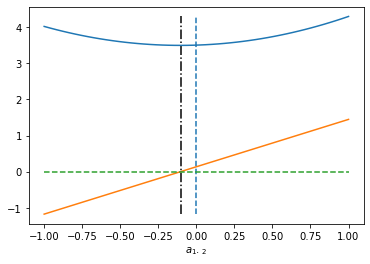

In [53]:
def C_pij_n(variables, i = 1, j = 1, l = 0.01):
    """Calculate the derivative of C w.r.t p"""
    
    P, A = variables
    
    derivative = 0
    
    last = n - 1
    
    P_perm = P # P_ds_to_P_perm(P)
    
    for t in range(1, length):
        
        for k in range(n):
            val = np.matmul(P_perm, series[t])[k]
            est = np.matmul(A, np.matmul(P, series[t - 1]))[k]
        
            # derivative:
            derivative_k = 0
            
            # always contributing
            derivative_k -= A[k][i - 1] * (series[t - 1][j - 1] - series[t - 1][last]) 
            derivative_k -= A[k][last]  * (series[t - 1][last]  - series[t - 1][j - 1])
            
            # last one
            if k == last:
                 derivative_k += series[t][last]  - series[t][j - 1]
            if k == i - 1:
                 derivative_k += series[t][j - 1] - series[t][last]
                
            derivative += 2 * (val - est) * derivative_k
        
    return derivative / (length - 1)

P = np.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]])
print(P_hat, A_hat)
C_pij_n([P, A])

verify_gradient_a(1, 2, P_hat, A_hat)

In [205]:
# for each row
for _ in range(n):
    # get largest entry in P
    i, j = np.unravel_index(np.argmax(P_2, axis=None), P_2.shape)
    
    # set all other values in that row and column to zero
    for i1 in range(n):
        P_2[i][i1] = 0
        P_2[i1][j] = 0
        
    # set the largest entry in P to 1
    P_2[i][j] = 1

    print(P_2, end = "\n\n")

[[ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]

[[ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]

[[ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]



#### Approach 2, index with relatively largest entry in row gets 1, set other values in the corresponding row and column to zero.

In [798]:
# reset P
P_2 = P_hat.copy()

In [799]:
# for each row
for _ in range(n):
    # Normalize each row by dividing by its smallest non-zero entry
    for i in range(n):
        P_2[i] /= np.min(P_2[i][np.nonzero(P_2[i])])

    # get largest entry in P
    i, j = np.unravel_index(np.argmax(P_2, axis=None), P_hat.shape)

    # set all other values in that row and column to zero
    for i1 in range(n):
        P_2[i][i1] = 0
        P_2[i1][j] = 0

    # set the largest entry in P to 1
    P_2[i][j] = 1

    print(P_2, end = "\n\n")

[[1.02448107 1.01222246 0.        ]
 [0.         0.         1.        ]
 [1.07494886 1.03132168 0.        ]]

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]



#### Approach 3, index with relatively largest entry in column gets 1, set other values in the corresponding row and column to zero.

In [800]:
# reset P
P_2 = P_hat.copy()

In [801]:
# for each row
for _ in range(n):
    # Normalize each row by dividing by its smallest non-zero entry
    for j in range(n):
        P_2[:, j] /= np.min(P_2[:, j][np.nonzero(P_2[:, j])])

    # get largest entry in P
    i, j = np.unravel_index(np.argmax(P_2, axis=None), P_hat.shape)

    # set all other values in that row and column to zero
    for i1 in range(n):
        P_2[i][i1] = 0
        P_2[i1][j] = 0

    # set the largest entry in P to 1
    P_2[i][j] = 1

    print(P_2, end = "\n\n")

[[0.         1.00396531 1.02290873]
 [0.         1.00824311 1.08284169]
 [1.         0.         0.        ]]

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]



#### Approach 4, Hungarian Algorithm

In [778]:
from scipy import optimize

# get row and index of the corresponding ones of the Hungarian algorithm
row_ind, col_ind = optimize.linear_sum_assignment(P_hat)

# initialize P_matrix
P_matrix = np.array(np.zeros((n, n)))

# assign ones to the corresponding entries
for i in range(n):
    P_matrix[row_ind[i]][col_ind[i]] = 1

print(np.rot90(P_matrix))

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Conclusion
Using gradient descent to iteratively and alternatingly update the $n^2$ (or $\frac{n(n+1)}{2}$ if $A$ is LT) parameters in $A$ and the $(n - 1)^2$ parameters in $P$, we arrive slowly but surely at the global optimum. We can speed this up by exploiting the fact that all partial derivatives are linear, hence we can find the optimum for each parameter quickly at each iteration.

If we pick $P = I$, then this method can quickly retrieve the unerlying values of $A$, regardless whether $A$ is full or LT.

If we generate $A$ uniformly at random, and take the lower triangle, and do not use any $P$, we see that all entries $p_{ij}$ in $P$ tend to be close to $\frac{1}{n}$.

If we generate the data with any doubly stochastic $P$, then we see that the values of $\hat{P}$ tend to $\frac{1}{n}$, and do not reveal the underlying values of the actual $P$.

If we generate data with a permutation matrix $P = \begin{pmatrix} 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$, the matrix $\hat{P}$ again tends to a uniformly doubly stochastic matrix.

### Misc
#### Plot cost function and derivative with respect to $p_{ij}$

In [107]:
def verify_gradient_p(i, j, P = P, A = A):
    print(P)
    print(f"{i} {j}, ..., ", end = " ")
    x_lim_1, x_lim_2 = -0, 1
    p_list = np.linspace(x_lim_1, x_lim_2, 50)
    results = [[], []]

    for p in p_list:
        old_p = P[i - 1][j - 1]
        
        P[i - 1][n - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - p)
        P[i - 1][j - 1] = p
        
        results[0].append(C_n([P, A]))
        results[1].append(C_pij_n([P, A], i = i, j = j))

        P[i - 1][n - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - old_p)
        P[i - 1][j - 1] = old_p
        
    plt.ylim(0, 10)
    plt.xlabel(f"$p_{{{str(i) + str(j)}}}$")
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        # plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        # plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--', label = r"$y = 0$")
        # plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        # plt.plot(p_list, results[1])
        # plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--')
        # plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

[[0.66608028 0.22408589 0.10983383]
 [0.27955255 0.20080197 0.51964547]
 [0.05402238 0.5752864  0.37069122]]
1 1, ...,  [[0.66608028 0.22408589 0.10983383]
 [0.27955255 0.20080197 0.51964547]
 [0.05402238 0.5752864  0.37069122]]
1 2, ...,  [[0.66608028 0.22408589 0.10983383]
 [0.27955255 0.20080197 0.51964547]
 [0.05402238 0.5752864  0.37069122]]
2 1, ...,  [[0.66608028 0.22408589 0.10983383]
 [0.27955255 0.20080197 0.51964547]
 [0.05402238 0.5752864  0.37069122]]
2 2, ...,  

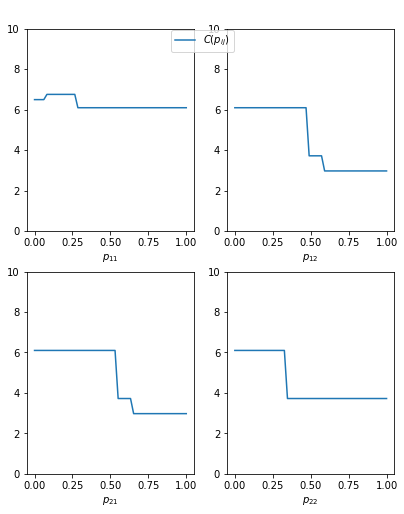

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]] [[ 0.39293837  0.          0.        ]
 [ 0.10262954  0.43893794  0.        ]
 [ 0.9615284   0.36965948 -0.0381362 ]]


In [118]:
P_hat = gen_P(n)

# Create a Position index
plt.figure(figsize = (3 * (n - 1), 3 * (n - 1)))
plt.subplots_adjust(bottom = -0.15, left = 0.05)
# total number of subplots
subplots = range(1, (n - 1) ** 2 + 1)

# create figure
fig = plt.figure(1)

# plot gradient for each p_ij
for k in range((n - 1) ** 2):
    ax = fig.add_subplot(n - 1, n - 1, subplots[k])
    verify_gradient_p(k // (n - 1) + 1, k % (n - 1) + 1, P = P_hat)

fig.legend(loc = 'upper center', ncol = 5, borderaxespad = 3.0)
plt.show()

print(P, A)

#### Plot cost function and derivative with respect to $a_{ij}$

In [47]:
def verify_gradient_a(i, j, P = P, A = A):
    print(P, A)
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-1.0, 1.0, 50)
    results = [[], []]

    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a

        results[0].append(C_n([P, A]))
        results[1].append(C_aij_n([P, A], i = i, j = j))

    A[i - 1][j - 1] = a_temp
        
    plt.xlabel(f"$a_{i}._{j}$")
    
    if i == 1 and j == 1:
        plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
        plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
        plt.plot([-1, 1], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")
    else:
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([-1, 1], [0, 0], linestyle = '--')
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
1 1, ...,  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
2 1, ...,  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
2 2, ...,  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
3 1, ...,  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
3 2, ...,  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.06383982 0.         0.        ]
 [0.26178619 0.25999194 0.        ]
 [0.09215475 0.26729073 0.31937978]]
3 3, ...,  

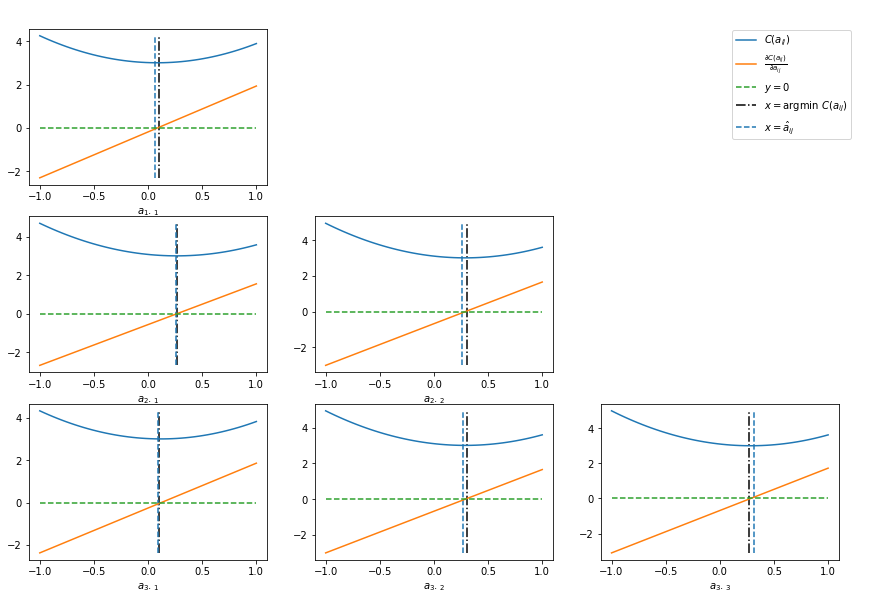

In [49]:
# Create a Position index
plt.figure(figsize = (3 * n, 3 * (n - 1)))
plt.subplots_adjust(bottom = -0.35, left = -0.35)

position = range(1, n ** 2 + 1)

fig = plt.figure(1)

for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    if k // n >= k % n:
        ax = fig.add_subplot(n, n, position[k])
        verify_gradient_a(k // n + 1, k % n + 1)

fig.legend(loc = 'upper right', ncol = 1, borderaxespad = 3.0)
plt.show()

#### Generate a random doubly stochastic matrix

#### Slow (actual) gradient descent, overwriting the values in actual $A$ and $P$

In [494]:
def gradient_descent(k):
    """
    Run Gradient Descent with Learning Parameter L on the kth variable until convergence.
    k is a number between 1 and ...
    """
    
    global L
    
    # If k is between 1 and n^2, estimate a_{k//n + 1, k%n + 1}
    if 1 <= k <= n ** 2:
        i = (k - 1) // n + 1
        j = (k - 1) % n + 1
        
        # lower triangular constraint: , j !> i
        if i >= j:
            # optimize A[(k-1)//n][(k-1)%n]
            # print(f"Optimizing A[{(k-1)//n}][{(k-1)%n}].")
            a_der, a_old = C_aij_n([P, A], i, j), 1e10
            while abs(a_der) > 1e-9 and abs(a_der) < abs(a_old):
                a_old = a_der
                A[i - 1][j - 1] -= L * a_der
                a_der = C_aij_n([P, A], i, j)
                # print(a_der)
        
    elif n ** 2 < k <= n ** 2 + (n - 1) ** 2:
        i = (k - n ** 2 - 1) // (n - 1) + 1
        j = (k - n ** 2 - 1) % (n - 1) + 1
        
        # print(f"Optimizing P[{i}][{j}].")
        p_der, p_old = C_pij_n([P, A], i, j), 1e10
        while abs(p_der) > 1e-9 and abs(p_der) < abs(p_old):
            p_old = p_der
            p_dif = L * p_der
            P[i - 1][j - 1] -= p_dif
            P[i - 1][n - 1] += p_dif
            P[n - 1][j - 1] += p_dif
            P[n - 1][n - 1] -= p_dif
            
            p_der = C_pij_n([P, A], i, j)
            if abs(p_old) < abs(p_der):
                print("A")
                L /= 10
                print(L)
                break
            
L = 0.01
cost, old_cost = C_n([P, A]), 1e10
while old_cost - cost > 1e-6:
    old_cost = cost
    for k in range(1, n ** 2 + (n - 1) ** 2 + 1):
        gradient_descent(k)
        print(round(C_n([P, A]), 6), end = ", ")
    cost = C_n([P, A])
    print("Cost difference:", str(old_cost - cost))

print(C_n([P, A]))
print(P, A)

NameError: name 'L' is not defined

#### Example of finding the zero point with only two evaluations in a linear equation

In [911]:
x1, x2 = 0.2, 0.5
a_tmp = A[0][0]
A[0][0] = x1
y1 = C_aij_n([P, A], 1, 1) 
A[0][0] = x2
y2 = C_aij_n([P, A], 1, 1) 
A[0][0] = a_tmp

a = (y1 - y2) / (x1 - x2)
b = y1 - a * x1
x_opt = -b / a

print(x_opt)
A[0][0] = x_opt
y_opt = C_aij_n([P, A], 1, 1) 
A[0][0] = a_tmp
print(y1, y2, y_opt)

-0.02870846773726601
0.09051323428652015 0.20924067168577629 3.222869641054008e-18
